# 0.課題

* ⓪ リーク変数を削除
* ① 前処理(欠損値処理/無相関化/白色化)
* ② モデルの選定
* ③ モデルの検証
    ・正則化
    ・交差検証(CV)


## 1. ライラブリimport

In [ ]:
# Basic Library
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# sklearn utility
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss,f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics   
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


## sklearn ensembles 
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression #線形回帰のライブラリ
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

## パラメータ調整
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid

## 1.1　データ読み込み

In [ ]:
df = pd.read_csv("../input/ks-projects201801-ver2/ks_projects201801_ver2.csv")
# リーク変数の削除
df = df.drop(["Unnamed: 0","pledged", "backers", "usd pledged", "usd_pledged_real"],axis= 1)
df.head()

,goal,state,usd_goal_real,period,Art,Comics,Crafts,Dance,Design,Fashion,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,1000.0,0,1533.95,58,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,30000.0,0,30000.00,59,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,45000.0,0,45000.00,44,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,5000.0,0,5000.00,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,50000.0,1,50000.00,34,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# 2.前処理

* 予めダミー化を行ったデータ(work1)を活用

## 2.1 欠損値処理

In [ ]:
# 数値データ列を抽出
num_col = df.iloc[:, :4].drop("state", axis=1)
num_col.head()

,goal,usd_goal_real,period
0,1000.0,1533.95,58
1,30000.0,30000.00,59
2,45000.0,45000.00,44
3,5000.0,5000.00,29
4,50000.0,50000.00,34


In [ ]:
def detect_outliers(df, n, features):
    """
    -----------------
    df : DataFrame
    n : 閾値
    features : 対象カラム
    ------------------
    外れ値のあるindexを抽出.
    """
    outlier_indices = []
    num = 1.5 

    for col in features:
        q1 = np.percentile(df[col], 25) # 第1四分位数
        q3 = np.percentile(df[col], 75) # 第3四分位数
        iqr = q3 - q1 # 四分位範囲
        
        outlier_step = num * iqr
        # 第1四分位数以下、第3四分位数以上の値を持つindex抽出
        outlier_list_col = df[(df[col] < q1 - outlier_step) | (df[col] > 3 + outlier_step)].index
        # 配列を結合
        outlier_indices.extend(outlier_list_col)
    # 辞書型(外れ値を持つindex:出現回数)データ生成
    outlier_indices = Counter(outlier_indices)
    # n列以上外れ値を持っているレコードのindex抽出
    multiple_outliers = list(k for k , v in outlier_indices.items() if v > n)
    
    return multiple_outliers

#  外れ値を持つindexを抽出
outliers_rows =detect_outliers(df, 0, num_col.columns)
# 外れ値を持つレコード削除
df= df.drop(outliers_rows, axis = 0).reset_index(drop=True)

In [ ]:
# 外れ値レコード削除によりデータ数削減
len(df)

223621

## 2.2 無相関化

In [ ]:
tmp = df.iloc[:, :4]
tmp.head()

,goal,state,usd_goal_real,period
0,5000.0,0,5000.00,29
1,25000.0,0,25000.00,44
2,2500.0,0,2406.39,29
3,12500.0,1,12500.00,29
4,5000.0,0,5000.00,29


### before

#### 相関係数

In [ ]:
tmp.corr().style.background_gradient("summer_r")

,goal,state,usd_goal_real,period
goal,1.000000,-0.126820,0.973368,0.102649
state,-0.126820,1.000000,-0.128770,-0.036511
usd_goal_real,0.973368,-0.128770,1.000000,0.099818
period,0.102649,-0.036511,0.099818,1.000000


#### 散布図/分布

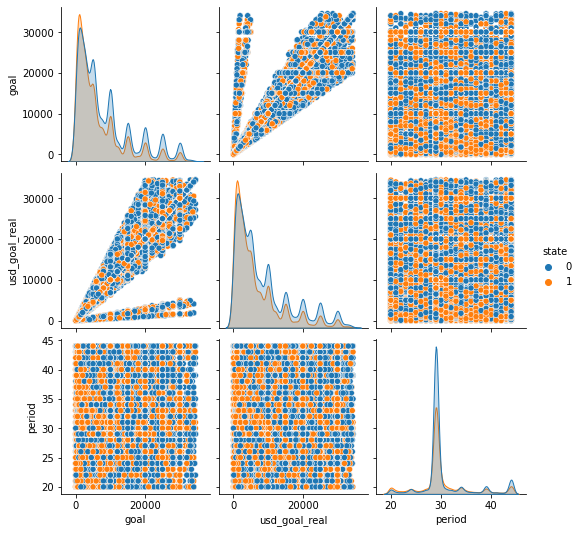

In [ ]:
before = tmp
sns.pairplot(tmp, hue="state")

#### VIF(多重共線性）

   VIF Factor       features
0   10.825221           goal
1   10.822945  usd_goal_real
2    1.002036         period


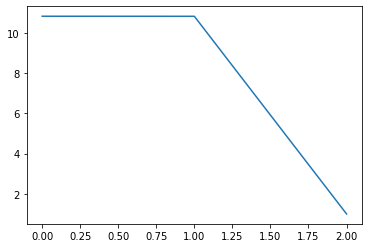

In [ ]:
def check_multico(df):
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    #vifを計算する
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns

    #vifを計算結果を出力
    print(vif)

    #vifをグラフ化
    plt.plot(vif["VIF Factor"])
    
# 多重共線性を確認
check_multico(num_col)

In [ ]:
# 通常データ（比較用）
df_origin = pd.concat([before,df.iloc[:, 4:]], axis=1)
df_origin

,goal,state,usd_goal_real,period,Art,Comics,Crafts,Dance,Design,Fashion,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,5000.0,0,5000.00,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,25000.0,0,25000.00,44,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2500.0,0,2406.39,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,12500.0,1,12500.00,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5000.0,0,5000.00,29,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223616,1700.0,0,1700.00,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
223617,6500.0,0,6500.00,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
223618,1500.0,0,1500.00,26,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
223619,15000.0,0,15000.00,30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### after

In [ ]:
#  無相関化
def uncorrelated(df):
    """
    df : DataFrame
    """
    cov = np.cov(df, rowvar=0) # 共分散
    _, S = np.linalg.eig(cov)  # 固有ベクトル
    uncorr = pd.DataFrame(np.dot(S.T, df.T).T,columns=df.columns)
    
    return uncorr

tmp2 = tmp.drop("state", axis=1)
after =  uncorrelated(tmp2)
after["state"] = tmp["state"]

#### 相関係数

In [ ]:
after.corr().style.background_gradient("summer_r")

,goal,usd_goal_real,period,state
goal,1.000000,-0.000000,-0.000000,0.128664
usd_goal_real,-0.000000,1.000000,0.000000,-0.008291
period,-0.000000,0.000000,1.000000,-0.023628
state,0.128664,-0.008291,-0.023628,1.000000


#### 散布図/分布

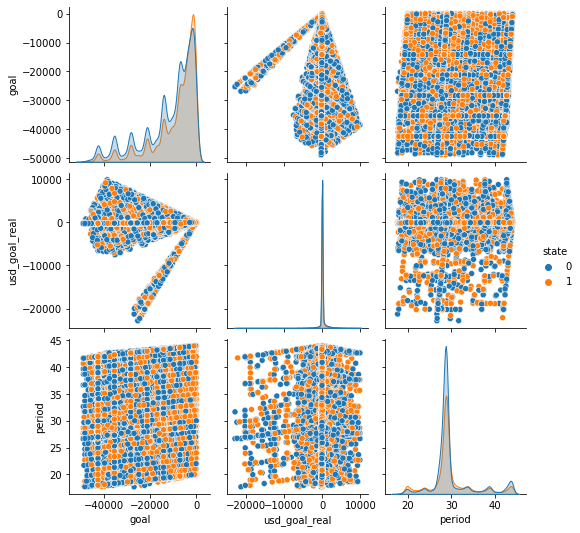

In [ ]:
sns.pairplot(after, hue="state")

#### 多重共線性

   VIF Factor       features
0    1.931407           goal
1    1.000043  usd_goal_real
2    1.931448         period


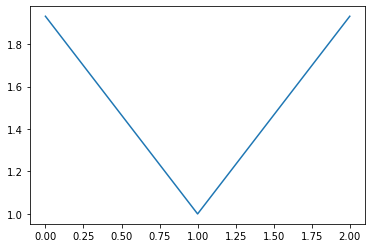

In [ ]:
# 多重共線性を確認
check_multico(after.iloc[:, :4].drop("state", axis=1))

In [ ]:
# 無相関化データ（比較用）
df_uncorre = pd.concat([after,df.iloc[:, 4:]], axis=1)
df_uncorre

,goal,usd_goal_real,period,state,Art,Comics,Crafts,Dance,Design,Fashion,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,-7070.968918,-37.657049,28.661845,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-35354.839789,-188.280215,42.309227,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-3468.941327,-84.668079,28.830809,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-17677.420227,-94.140456,28.154613,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-7070.968918,-37.657049,28.661845,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223616,-2404.130343,-12.804349,28.885027,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
223617,-9192.259180,-48.953730,28.560399,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
223618,-2121.291498,-11.297976,25.898554,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
223619,-21212.904044,-112.968308,28.985536,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 2.3 白色化(標準化）

### ①標準化（無相関化していないデータに対して）

In [ ]:
def standardization(df):
    sc = StandardScaler()
    return pd.DataFrame(sc.fit_transform(df), columns=df.columns)


tmp = standardization(df_origin.iloc[:, :4].drop("state", axis=1))
df_std = df_origin
# goal, usd_goal_real, period
df_std.iloc[:, 0] = tmp.iloc[:, 0] 
df_std.iloc[:, 2] = tmp.iloc[:, 1]
df_std.iloc[:, 3] = tmp.iloc[:, 2]
df_std

,goal,state,usd_goal_real,period,Art,Comics,Crafts,Dance,Design,Fashion,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,-0.324220,0,-0.329781,-0.270260,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2.319590,0,2.286762,2.738398,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.654696,0,-0.669095,-0.270260,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.667209,1,0.651423,-0.270260,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-0.324220,0,-0.329781,-0.270260,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223616,-0.760449,0,-0.761510,-0.270260,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
223617,-0.125934,0,-0.133540,-0.270260,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
223618,-0.786887,0,-0.787675,-0.871991,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
223619,0.997685,0,0.978491,-0.069682,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


   VIF Factor       features
0   19.038530           goal
1   19.027507  usd_goal_real
2    1.010649         period


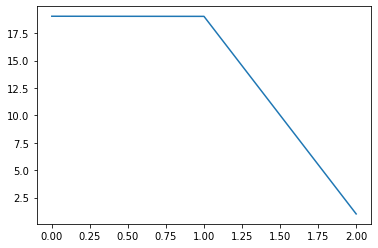

In [ ]:
# 多重共線性を確認
check_multico(df_std.iloc[:, :4].drop("state", axis=1))

### ②白色化

In [ ]:
def standardization(df):
    sc = StandardScaler()
    return pd.DataFrame(sc.fit_transform(df), columns=df.columns)

tmp = standardization(df_uncorre.iloc[:, :4].drop("state", axis=1))
df_white = df_uncorre
# goal, usd_goal_real, period
df_white.iloc[:, 0] = tmp.iloc[:, 0] 
df_white.iloc[:, 1] = tmp.iloc[:, 1]
df_white.iloc[:, 2] = tmp.iloc[:, 2]
df_white

,goal,usd_goal_real,period,state,Art,Comics,Crafts,Dance,Design,Fashion,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,0.329229,-0.023691,-0.238264,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-2.318490,-0.145071,2.513626,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.666423,-0.061575,-0.204193,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.663666,-0.069208,-0.340543,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.329229,-0.023691,-0.238264,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223616,0.766102,-0.003663,-0.193261,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
223617,0.130650,-0.032794,-0.258720,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
223618,0.792580,-0.002449,-0.795460,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
223619,-0.994631,-0.084380,-0.172994,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


   VIF Factor       features
0         1.0           goal
1         1.0  usd_goal_real
2         1.0         period


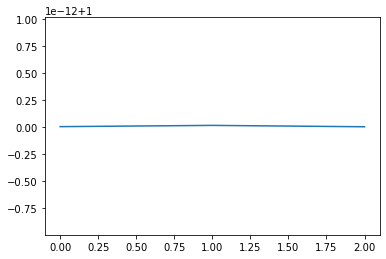

In [ ]:
# 多重共線性を確認
check_multico(df_white.iloc[:, :4].drop("state", axis=1))

# 3.データ仕上げ(train/test 仕分け)

In [ ]:
y = df_white["state"]
x = df_white.drop(labels = ["state"],axis = 1)
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.2)

# 4.モデル作成

## 4.1　モデルの選定

In [ ]:
# #機械学習モデルをリストに格納
models = []

models.append(("ロジスティック回帰","LogisticRegression",LogisticRegression(random_state=0)))
models.append(("決定木", "DecisionTree", DecisionTreeClassifier(random_state=0)))
models.append(("k近傍法","k-Nearest Neighbors",KNeighborsClassifier()))
models.append(("サポートベクターマシン(線形)","Support Vector Machine(linear)",LinearSVC(random_state=0)))

names_jp = []
names_en = []
results = []
    
for name_jp,name_en,model in models:

    print(model.fit(train_x.iloc[0:10000, :],train_y.iloc[0:10000]),"\n")
    
    kfold = KFold(n_splits=5, shuffle=True)
    result = cross_val_score(model,train_x.iloc[0:10000, :],train_y.iloc[0:10000], cv = kfold, scoring = "accuracy")
    names_jp.append(name_jp)
    names_en.append(name_en)
    results.append(result)

LogisticRegression(random_state=0) 

DecisionTreeClassifier(random_state=0) 

KNeighborsClassifier() 

LinearSVC(random_state=0) 



In [ ]:
list_df = pd.DataFrame(columns=['識別子','識別子(英名)','スコア(平均)'])
 
for i in range(len(names_jp)):
    list_df = list_df.append( pd.Series( [names_jp[i],names_en[i],results[i].mean()], index=list_df.columns ), ignore_index=True)

list_df

,識別子,識別子(英名),スコア(平均)
0,ロジスティック回帰,LogisticRegression,0.6163
1,決定木,DecisionTree,0.5703
2,k近傍法,k-Nearest Neighbors,0.5870
3,サポートベクターマシン(線形),Support Vector Machine(linear),0.6178


## 4.2 ロジスティック回帰

### グリッドサーチ

In [ ]:
# パラメータ候補の全組み合わせを試し、平均的に優れた性能を示すパラメータ探索
from sklearn.model_selection import GridSearchCV

# グリッドサーチ(LogisticRegressionのパラメーター）
parameters = [
    {'solver': ['liblinear', 'saga'], 'penalty':['l1', 'l2'], 'C': [0.1, 1, 10, 100], "random_state":[0]},
    {'solver': ['newton-cg', 'sag', 'lbfgs' ], 'penalty':['l2'], 'C': [0.1, 1, 10, 100],"random_state":[0]},
]

#グリッドサーチ実行
classifier = GridSearchCV(LogisticRegression(), parameters, cv=3, n_jobs=-1)
classifier.fit(train_x.iloc[0:10000, :], train_y.iloc[0:10000])
print("Accuracy score (train): ", classifier.score(train_x.iloc[0:10000, :], train_y.iloc[0:10000]))
print("Accuracy score (test): ", classifier.score(val_x.iloc[0:10000, :], val_y.iloc[0:10000]))
print('best params: {}'.format(classifier.best_estimator_)) 
print('best val score:  {:0.3f}'.format(classifier.best_score_))


Accuracy score (train):  0.6203
Accuracy score (test):  0.6048
best params: LogisticRegression(C=1, random_state=0, solver='saga')
best val score:  0.615


 スコア・パラメータのヒートマップ（縦軸 : C , 横軸 : penalty)

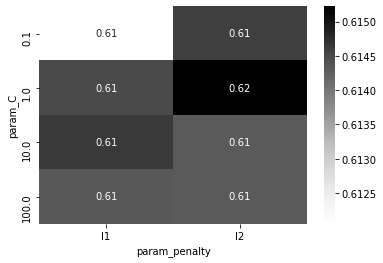

In [ ]:
classifier.cv_results_
cv_result = pd.DataFrame(classifier.cv_results_)
cv_result_pivot = cv_result.pivot_table('mean_test_score', 'param_C', 'param_penalty')
heat_map = sns.heatmap(cv_result_pivot, cmap='Greys', annot=True);

スコア・パラメータのヒートマップ（縦軸 : C , 横軸 : solver)

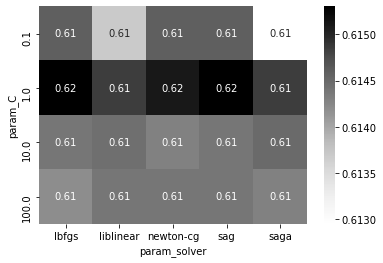

In [ ]:
cv_result_pivot = cv_result.pivot_table('mean_test_score', 'param_C', 'param_solver')
heat_map = sns.heatmap(cv_result_pivot, cmap='Greys', annot=True);

## 多項式化

In [ ]:
degrees = np.arange(1,4)#degreeの値を4つ指定する

for degree in degrees:
    est = make_pipeline(PolynomialFeatures(degree), LogisticRegression())
    est.fit(train_x.iloc[0:10000, :], train_y.iloc[0:10000])
    print("degree: {} / score :{}".format(degree, est.score(val_x, val_y)))

degree: 1 / score :0.613527110117384
degree: 2 / score :0.611648965902739
degree: 3 / score :0.612945779765232


### k分割交差検証

In [ ]:
# k分割交差検証の実行(最適な組み合わせ)
scores = cross_val_score(make_pipeline(PolynomialFeatures(3),
                                       classifier.best_estimator_),
                                       train_x.iloc[0:5000, :], train_y.iloc[0:5000])

#結果表示
print('Cross validation scores : {}'.format(scores))
print('Cross validation scores : {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

Cross validation scores : [0.569 0.572 0.578 0.569 0.58 ]
Cross validation scores : 0.574+-0.005


## 4.3 SVC

### グリッドサーチ

In [ ]:
SVC_grid = {SVC(): {"C": [0.1, 1, 10, 100,1000],# ペナルティ
                    "kernel": ["linear", "rbf"],#線形カーネル関数, ガウスカーネル関数
                    "gamma": [0.1, 1, 10, 100,1000],#分散の逆数
                    "random_state": [0]
                   }}

In [ ]:
max_score = 0

#グリッドサーチ（処理が終わらないためデータ量削減）
grid_train_x = train_x.iloc[0:1000, :]
grid_train_y = train_y.iloc[0:1000]
grid_val_x = val_x.iloc[0:1000, :]
grid_val_y = val_y.iloc[0:1000]

for model, param in SVC_grid.items():
    clf = GridSearchCV(model, param, cv=3)
    clf.fit(grid_train_x, grid_train_y)
    pred_y = clf.predict(grid_val_x)
    score = clf.score(grid_val_x, grid_val_y)

    if max_score < score:
        max_score = score
        best_param = clf.best_params_

In [ ]:
print("Accuracy score (train): ", clf.score(grid_train_x, grid_train_y))
print("Accuracy score (test): ", clf.score(val_x, val_y))
print('best params: {}'.format(clf.best_estimator_)) 
print('best val score:  {:0.3f}'.format(clf.best_score_))

Accuracy score (train):  0.745
Accuracy score (test):  0.580435997764114
best params: SVC(C=1, gamma=1, random_state=0)
best val score:  0.609


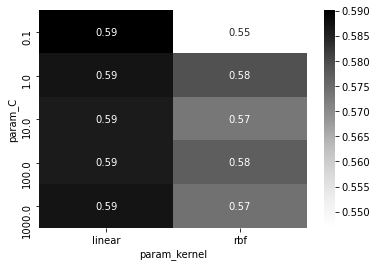

In [ ]:
cv_result = pd.DataFrame(clf.cv_results_)
cv_result_pivot = cv_result.pivot_table('mean_test_score', 'param_C', 'param_kernel')
heat_map = sns.heatmap(cv_result_pivot, cmap='Greys', annot=True);

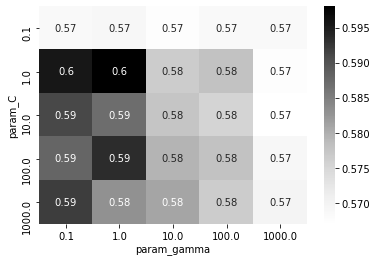

In [ ]:
cv_result_pivot = cv_result.pivot_table('mean_test_score', 'param_C', 'param_gamma')
heat_map = sns.heatmap(cv_result_pivot, cmap='Greys', annot=True);

In [ ]:
# k分割交差検証の実行(最適な組み合わせ)
scores = cross_val_score(clf.best_estimator_, train_x.iloc[0:5000, :], train_y.iloc[0:5000])

#結果表示
print('Cross validation scores : {}'.format(scores))
print('Cross validation scores : {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

Cross validation scores : [0.597 0.586 0.611 0.579 0.62 ]
Cross validation scores : 0.599+-0.015


## k分割交差検証

### 線形SVC

In [ ]:
# k分割交差検証の実行
scores = cross_val_score(SVC(C=1,kernel="linear", gamma=1, random_state=0),
                                       train_x.iloc[0:10000, :], train_y.iloc[0:10000])

#結果表示
print('Cross validation scores : {}'.format(scores))
print('Cross validation scores : {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

Cross validation scores : [0.58  0.6   0.6   0.622 0.604]
Cross validation scores : 0.601+-0.013


### 非線形SVC

In [ ]:
# k分割交差検証の実行
scores = cross_val_score(SVC(C=1,kernel="rbf", gamma=1, random_state=0),
                                       train_x.iloc[0:10000, :], train_y.iloc[0:10000])

#結果表示
print('Cross validation scores : {}'.format(scores))
print('Cross validation scores : {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

Cross validation scores : [0.592  0.5985 0.6225 0.635  0.607 ]
Cross validation scores : 0.611+-0.016


## 4.4 特微量選択

In [ ]:

from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    """
    estimator : 学習モデル
    k_features : 特微量数(選択する特微量の個数)
    scoring : 評価指標
    -------------------------
    逐次後退選択（Sequential backward Selection)実行クラス.
    """
    def __init__(self, estimator, k_features, scoring=accuracy_score,test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        # 全ての特微量でスコア算出
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]
        # 特微量が指定した個数になるまで処理を繰り返す
        while dim > self.k_features:
            scores = []
            subsets = []
            # 特微量の部分集合を表す列インデックスの組み合わせごとに処理を反復
            for p in combinations(self.indices_, r=dim - 1):
                # スコアを算出して格納
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                # 特微量の部分集合を表す列インデックスの組み合わせごとに処理を反復
                subsets.append(p)
            # 最良のスコアのインデックスを抽出
            best = np.argmax(scores)
            # 最良のスコアとなる列インデックスのリストを格納
            self.indices_ = subsets[best]
            # スコアを格納
            self.subsets_.append(self.indices_)
            # 特微量の個数を1つだけ減らして次のステップへ
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        # 抽出した特微量を返す
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        # 指定された列番号の特微量を抽出してモデル生成
        self.estimator.fit(X_train.iloc[:, list(indices)], y_train)
        y_pred = self.estimator.predict(X_test.iloc[:, list(indices)])
        # 正解値と予測値を用いてスコアを算出
        score = self.scoring(y_test, y_pred)

        return score

In [ ]:
# 最も良い精度のモデルを選択
model = make_pipeline(PolynomialFeatures(3),classifier.best_estimator_)
# 逐次後退選択のインスタンス生成（特微量の個数が1になるまで特微量を選択）
sbs = SBS(model, k_features=1)
# 逐次後退選択を実行
sbs.fit(train_x.iloc[0:1000,:], train_y.iloc[0:1000])

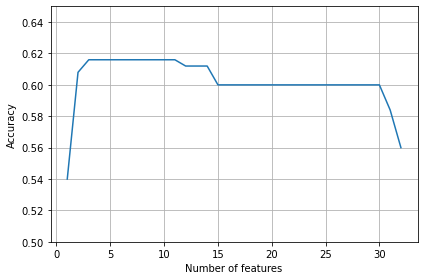

In [ ]:
# 得微量の個数のリスト 
k_feat = [len(k) for k in sbs.subsets_]
# 横軸を得微量の個数、縦軸をスコアとした折れ線グラフのプロット
plt.plot(k_feat, sbs.scores_)
plt.ylim([0.5, 0.65])
plt.ylabel("Accuracy")
plt.xlabel("Number of features")
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# 特微量部分集合（k=10)の内容を確認
k10 = list(sbs.subsets_[10])
print(df_white.columns[1:][k10])

Index(['usd_goal_real', 'state', 'Art', 'Comics', 'Crafts', 'Dance', 'Design',
       'Fashion', 'Film & Video', 'Food', 'Games', 'Journalism', 'Music',
       'Photography', 'Publishing', 'Technology', 'Theater', 'AUD', 'CAD',
       'CHF', 'DKK', 'EUR'],
      dtype='object')


In [ ]:
# 全特微量を用いたモデル
model.fit(train_x, train_y)
# 訓練の正解率
print("Training accuracy : {}".format(model.score(train_x, train_y)))
# テストの正解率
print("Test accuracy : {}".format(model.score(val_x, val_y)))

Training accuracy : 0.6258552455057688
Test accuracy : 0.6222247065399664


In [ ]:
# 10の特微量を用いたモデル
model.fit(train_x.iloc[:, k10], train_y)
# 訓練の正解率
print("Training accuracy : {}".format(model.score(train_x.iloc[:, k10], train_y)))
# テストの正解率
print("Test accuracy : {}".format(model.score(val_x.iloc[:, k10], val_y)))

Training accuracy : 0.6233621769072534
Test accuracy : 0.6195416433761878


# 5.まとめ

* リークの変数を使った前回の精度と比べると、やはり落ち幅がかなり大きい。
* 以前と比べて、様々な手法でモデルを検証できた。しかし、まだ浅い検証しかできていない。
 今後は精度向上のために、もう少し踏み込んだ「特微量生成・パラメータ探索」などの知見を高めていきたい。